# <p style="text-align: center;"> Variational Quantum Linear Solver on Rigetti QCS </p>

<p style="text-align: center;"> Ryan LaRose, Department of Computational Mathematics, Science, and Engineering & Department of Physics and Astronomy, Michigan State University. </p>

<img src="main.png" alt="Overview of VQLS">

### <p style="text-align: center;"> Abstract </p>

<p style="text-align: justify;"> The variational quantum linear solver (VQLS) [1] is an algorithm for solving linear systems on near-term quantum computers. While VQLS does not offer performance guaruntees like other quantum linear systems algorithms [2-3], the ability to run on near-term computers makes it an interesting problem-specific benchmark. In this notebook, we provide a brief tutorial of VQLS and show results of running VQLS on Rigetti QCS for example linear systems. </p>

## <p style="text-align: center;"> Notebook Setup </p>

<p style="text-align: justify;"> We use pyQuil to write the VQLS algorithm and send job submissions to Rigetti QCS. In the notebook, we use the Rigetti QVM for tutorial purposes. When running on the device, the code written in the notebook is converted to a script and executed on the QPU. </p>

In [1]:
"""Imports."""
from itertools import product
from math import pi
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import (dual_annealing, fmin, fmin_powell, fmin_cobyla, minimize)

import pyquil
from pyquil import Program, get_qc
import pyquil.gates as gates

import vqls

In [2]:
"""Constants and other setup."""
np.set_printoptions(precision=3)
%matplotlib inline

# <p style="text-align: center;"> The VQLS Algorithm </p>

A linear system $A \mathbf{x} = \mathbf{b}$ is defined by a matrix $A \in \mathbb{C}^{N \times N}$ and vector $\mathbf{b} \in \mathbb{C}^{N}$. Given $A$ and $\mathbf{b}$ as input, the goal is to output $\mathbf{x} \in \mathbb{C}^{N}$, or an approximate solution $\mathbf{\bar{x}}$ where $|| \mathbf{\bar{x}} - \mathbf{x} || \le \delta$. 

### <p style="text-align: center;"> Problem Setup </p>

<p style="text-align: justify;"> How can we solve linear systems of equations with a (near-term) quantum computer? Without loss of generality, we can express the matrix $A$ is a linear combination of Paulis</p>

\begin{equation}
    A = \sum_{l = 1}^{L} a_l A_l .
\end{equation}

<p style="text-align: justify;"> The vector $|\mathbf{b}\rangle$ is assumed to have some unitary $B$ which prepares it from the ground state, i.e. $B|0\rangle = |\mathbf{b}\rangle$. We can also take $B = \sum_{m = 1}^{M} b_m B_m$ as a linear combination of Paulis. </p>

We want to prepare a state

\begin{equation}
    |\mathbf{\theta}\rangle := V(\mathbf{\theta}) |0\rangle 
\end{equation}

<p style="text-align: justify;"> which has high fidelity $| \langle \theta | \mathbf{x} \rangle |^2$ with the solution $|x\rangle$ of the linear system $A |\mathbf{x}\rangle = |\mathbf{b}\rangle $. Equivalenlty, we want a state $|\theta\rangle$ such that $A |\theta\rangle$ is close to $|\mathbf{b}\rangle$. By maximizing the fidelity $|\langle \mathbf{b} | A |\theta\rangle|^2$ where

\begin{equation}
    \langle \mathbf{b} | A |\theta\rangle = \langle 0 | B^\dagger A V(\theta) |0\rangle = \sum_{l = 1}^{L} c_l \langle 0 | B^\dagger A_l V(\theta) |0\rangle .
\end{equation}

one can obtain an approximate solution $|\theta_\text{opt}\rangle = V(\theta_\text{opt}) |0\rangle$ to the linear system. 

One way to compute the fidelity is via the Hadamard Test or extensions of the Hadamard Test [1]. Another way is described below.

### <p style="text-align: center;"> The Effective Hamiltonian Approach </p>

An interesting connection to other linear systems work [4] and variational algorithms literature [5] is to note that the above prescription is equivalent to minimizing the energy of an effective Hamiltonian

\begin{equation}
    H_{A, \mathbf{b}} \equiv H := A^\dagger ( I - |\mathbf{b}\rangle \langle \mathbf{b} | ) A
\end{equation}

<p style="text-align: justify;">
This can be seen by noting that $H$ is positive semidefinite and $H |\mathbf{x}\rangle = 0$. Thus, by minimizing $\langle \theta | H |\theta \rangle$, we can get an approximate solution to the linear system. A key advantage of this approach is the ability to compute expectation values in a hardware efficient manner. (That is, not using controlled gates required by the Hadamard test but instead using classical post-processing [5-7].) We use this <b>effective Hamiltonian approach</b> in our simulations below.
</p>

Noting that $H = A^\dagger A - A^\dagger P_{\mathbf{b}} A$ where $P_{\mathbf{b}} := |\mathbf{b}\rangle \langle \mathbf{b} |$ is the projector onto the $|\mathbf{b}\rangle$ state, we have two terms to evaluate. For the first, one can show that

\begin{equation}
    A^\dagger A = \sum_{l = 1}^{L} |a_l|^2 I + 2 \sum_{1 = l < k}^{L - 1} \text{Re} \, [a_l^* a_k ] A_l A_k .
\end{equation}

The expectation of the first summation can be computed classically, while the second requires $L (L - 1) / 2 = O(L^2)$ circuit evaluations. 

For the second term in the Hamiltonian $H$, one can see that

\begin{equation}
    A^\dagger P_{\mathbf{b}} A = \sum_{k = 1}^{L} \sum_{l = 1}^{L} a_k^* a_l A_k P_\mathbf{b} A_l .
\end{equation}

Assuming $B = \sum_{m = 1}^{M} b_m B_m$, the projector $P_\mathbf{b} = B|0\rangle \langle 0 | B^\dagger$ can be expanded as a linear combination of unitaries as well. Note that $|0\rangle\langle0| = (I + Z) / 2$. In general, there are $N M^2 L^2$ weighted Pauli operators in this term ($N = 2^n$ where $n$ is the number of qubits).  

<p style="text-align: justify;">
As mentioned, the <font color="green"><b>advantage</b></font> of this approach is the short-depth circuits for cost evaluation. The <font color="red"><b>disadvantage</b></font> of this approach is that it can lead to many terms in the Pauli expansion of $H_{A, \mathbf{b}}$. An interesting observation is the "physicality" of this effective Hamiltonian -- namely, physical Hamiltonians usually have (or are assumed to have) poly($n$) terms, while this Hamiltonian has $O(N)$ terms in the worst case. We remark that simplifications which reduce the number of terms in the effective Hamiltonian $H_{A, \textbf{b}}$ are usually possible. Additionally, computing $\langle H \rangle$ by exploiting simulataneous measurements of observables can mitigate the large number of terms. Finally, we remark that coefficients in the projector $|0\rangle \langle 0|$ on $n$ qubits are equal to $1 / 2^n$, and it can be a reasonable approximation to skip terms with small coefficients. </p>

# <p style="text-align: center;"> Linear System 1 </p>

<p style="text-align: justify;"> The first linear system we consider is an example from the VQLS paper. Our motivation for this is to compare results from the paper (which used older Rigetti computers) to results we get on the new computers. The linear system is a three- to five-qubit example given by </p>

\begin{equation}
    A_1 = I + 0.2 X_1 + 0.2 X_1 Z_2 .
\end{equation}

and $\mathbf{b}_1 = H_1 H_2 H_4 H_4 |0\rangle^{\otimes n}$. Here, $I, X, Y$ and $Z$ are the usual Pauli operators

\begin{equation}
    I := \left[ \begin{matrix}
    1 & 0 \\
    0 & 1 \\
    \end{matrix} \right], \qquad 
    X := \left[ \begin{matrix}
    0 & 1 \\
    1 & 0 \\
    \end{matrix} \right], \qquad 
    Y := \left[ \begin{matrix}
    0 & -i \\
    i & 0 \\
    \end{matrix} \right], \qquad 
    Z := \left[ \begin{matrix}
    1 & 0 \\
    0 & -1 \\
    \end{matrix} \right]
\end{equation}

and subscripts indicate which qubits the Paulis act on. For example, $X_1$ means $X$ on the first qubit, i.e. $XII$ on three qubits or $X I I I I$ on five qubits.


For concreteness, we can reduce to three qubits and view the $8 \times 8$ matrix of this linear system. (Of course this works for any number of qubits, but we quickly run out of room on the screen!)

In [3]:
"""View the matrix of a linear system."""
# Define the matrix of the linear system as weighted Paulis
Acoeffs = [1., 0.2, 0.2]
Aterms = ["III", "XII", "XZI"]

# Display the matrix
print("The matrix of the linear system is:")
print(np.real(vqls.matrix(Acoeffs, Aterms)))

The matrix of the linear system is:
[[1.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]


<font color="blue"><b>Note:</b></font> The matrix is quite sparse. This is expected for linear systems with only a few weighted Paulis, as Pauli strings are sparse matrices. 

Using the identity $H = (I + Z) / \sqrt{2}$, we can expand the $B$ unitary as 

\begin{align}
    B &= \frac{1}{2^2} (I + Z) \otimes (I + Z) \otimes I \otimes (I + Z) \otimes (I + Z) \\
      &= \frac{1}{2^2} \left[ IIIII + IIIIZ + IIIZI + IIIZZ + IZIII + IZIIZ + IZIZI + IZIZZ + \cdots \right]
\end{align}

## <p style="text-align: center;"> Three Qubit Tutorial </p>

Below we consider the three-qubit verstion of the linear system above. First, we define the linear system in terms of $A$ and $B$, then compute the effective Hamiltonian of the linear system. 

In [4]:
"""Terms in effective Hamiltonian for first linear system."""
# Number of qubits
n = 3

# Define the B matrix of the linear system
Bcoeffs = [1 / 2**(n / 2)] * 2**n
paulis = [["X", "Z"]] * n
prods = list(product(*paulis))
Bterms = ["".join(p) for p in prods]

# Define the A matrix of the linear system
Acoeffs = [1, 0.2, 0.2]
Aterms = ["III", "XII", "XZI"]

# Get the effective Hamiltonian
ham = vqls.effective_hamiltonian(Acoeffs, Aterms, Bcoeffs, Bterms)

# Display the effective Hamiltonian
nterms = len(ham)
print("Number of terms:", nterms)
print("H = ")
for ii in range(nterms):
    print(f"{round(ham[ii][0], 3)} \t* \t{ham[ii][1]}", (lambda ii: "+" if ii < nterms - 1 else "")(ii))

Number of terms: 12
H = 
(0.895+0j) 	* 	III +
(0.215+0j) 	* 	XII +
(0.34+0j) 	* 	XZI +
(0.02+0j) 	* 	IZI +
(-0.185+0j) 	* 	IIX +
(-0.175+0j) 	* 	IXI +
(-0.06+0j) 	* 	IZX +
(-0.175+0j) 	* 	IXX +
(-0.185+0j) 	* 	XIX +
(-0.175+0j) 	* 	XXI +
(-0.06+0j) 	* 	XZX +
(-0.175+0j) 	* 	XXX 


To evaluate these terms with a quantum computer, we first need a quantum computer! Below we select an appropriate `Aspen` lattice.

In [5]:
"""Get a quantum computer to run on."""
qcomputer = f"Aspen-7-{n}Q-B"  # Three qubit lattice for testing optimizer
lattice = get_qc(qcomputer, as_qvm=True)  # Change to as_qvm=False to run on QC. Must have reservation.

We can visualize the connectivity of this lattice by drawing the qubit topology. 

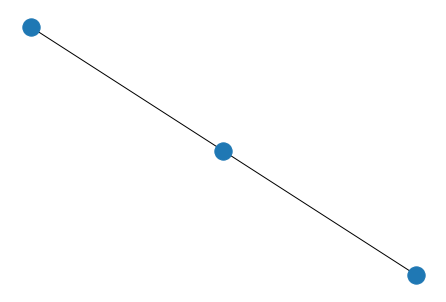

In [6]:
"""Visualize the qubit connectivity."""
graph = lattice.qubit_topology()
nx.draw(graph)

### <p style="text-align: center;"> Variational Ansatz </p>

The next and final ingredient we need to compute $\langle \theta | H | \theta \rangle$ is an ansatz state $|\theta\rangle$. We take this to be a product of $Y$-rotations on each qubit in the computer, obtained via `vqls.yansatz`.

In [7]:
"""Get an ansatz and visualize it."""
circ, creg = vqls.yansatz(lattice)
print(circ)

DECLARE ro BIT[3]
DECLARE theta REAL[3]
RY(theta[0]) 10
RY(theta[1]) 11
RY(theta[2]) 12



As we see, the main circuit is simply $Y$-rotations on each qubit where the parameters `theta[0], theta[1], theta[2]` are independent.

The following function defines the cost we want to minimize by varying the parameters in the ansatz. The cost is exactly the energy of the effective Hamiltonian $H_{A, \mathbf{b}}$ computed via `vqls.energy`. 

In [8]:
"""Cost function for linear system 1."""
def costLS1(angles, verbose: bool = False):
    val = vqls.energy(angles, ham, circ, creg, lattice, shots=10000)
    if verbose:
        print("Current angles:", angles)
        print("Current energy:", val)
    return val

In [9]:
"""Optimization: Testing fmin functions from scipy.optimize."""
start = time.time()
res = fmin(costLS1, x0=[pi / 2] * n, ftol=0.001, maxfun=50, args=(True,))
print("Runtime:", (time.time() - start) // 60, "minutes.")

/home/ryan/phd/rigettiVQLS/pyquil/lib/python3.6/site-packages/rpcq/_client.py:196: UserWarning: SIMPLE-WARNING: Chip specification contained fidelity 1.0d0 > 0.99999d0. Truncating to 0.99999d0.
  warn(f"{warning.kind}: {warning.body}")


Current angles: [1.571 1.571 1.571]
Current energy: 0.0428360000000014
Current angles: [1.649 1.571 1.571]
Current energy: 0.040632000000001306
Current angles: [1.571 1.649 1.571]
Current energy: 0.03146600000000144
Current angles: [1.571 1.571 1.649]
Current energy: 0.03639900000000157
Current angles: [1.623 1.623 1.623]
Current energy: 0.029096000000001454
Current angles: [1.649 1.649 1.649]
Current energy: 0.022103000000001705
Current angles: [1.545 1.676 1.676]
Current energy: 0.024159000000001485
Current angles: [1.606 1.745 1.614]
Current energy: 0.00969900000000129
Current angles: [1.623 1.833 1.597]
Current energy: 0.0064350000000012175
Current angles: [1.641 1.789 1.71 ]
Current energy: 0.006062000000001205
Current angles: [1.676 1.859 1.78 ]
Current energy: 0.02024100000000137
Current angles: [1.731 1.838 1.629]
Current energy: 0.008226000000001482
Current angles: [1.68  1.991 1.642]
Current energy: 0.008707000000001242
Current angles: [1.673 1.905 1.644]
Current energy: -0.0

In [10]:
"""Do the optimization."""
# start = time.time()
# res = minimize(costLS1, x0=[pi / 2] * n, method="COBYLA", args=(True,))
# print("Runtime:", (time.time() - start) // 60, "minutes.")

Current angles: [1.571 1.571 1.571]
Current energy: 0.03405600000000136
Current angles: [2.571 1.571 1.571]
Current energy: 0.1842060000000011
Current angles: [1.571 2.571 1.571]
Current energy: 0.1622370000000007
Current angles: [1.571 1.571 2.571]
Current energy: 0.3747590000000006
Current angles: [1.189 1.245 0.706]
Current energy: 0.4168310000000009
Current angles: [1.38  1.408 1.138]
Current energy: 0.1592320000000013
Current angles: [1.814 1.551 1.517]
Current energy: 0.05416100000000165
Current angles: [1.571 1.688 1.527]
Current energy: 0.01445600000000119
Current angles: [1.558 1.879 1.687]
Current energy: 0.009288000000001323
Current angles: [1.495 1.956 1.611]
Current energy: -0.001386999999998667
Current angles: [1.567 2.033 1.544]
Current energy: 0.0082490000000012
Current angles: [1.492 1.998 1.656]
Current energy: 0.00754900000000136
Current angles: [1.41  1.899 1.539]
Current energy: 0.0059550000000010705
Current angles: [1.459 1.993 1.646]
Current energy: 0.00899100000

In [11]:
"""Optimize by annealing."""
# start = time.time()
# res = dual_annealing(costLS1, bounds=[(0, 2 * pi)] * n, args=(True,))
# print("Runtime:", (time.time() - start) // 60, "minutes.")

'Optimize by annealing.'

In [ ]:
"""Compute energy at optimal angles."""
vqls.energy([1.61, 1.88, 1.61], ham, circ, creg, lattice)

### <p style="text-align: center;"> Compare the Quantum and Classical Solutions </p>

In [12]:
print("Minimum cost found:", res.fun)
print("Best found angles:", res.x)

Minimum cost found: 0.0009590000000012644
Best found angles: [1.501 1.958 1.607]


In [13]:
qxvec = vqls.qsolution(circ, res.x)
print(qxvec)

[0.283+0.j 0.264+0.j 0.421+0.j 0.393+0.j 0.294+0.j 0.274+0.j 0.437+0.j
 0.407+0.j]


In [15]:
"""Compare to classical solution."""
# Get the classical solution
Amat = vqls.matrix(Acoeffs, Aterms)
bvec = vqls.vector(Bcoeffs, Bterms)
xvec = np.linalg.solve(Amat, bvec)
xvec /= np.linalg.norm(xvec)

# ===========================
# Compare classical x vectors
# ===========================

print("Comparing x vectors:")
print("====================")

# Compute the fidelity
fidelity = abs(np.dot(qxvec.conj(), xvec))**2
print(r"| < xquantum | xclassical > |^2 =", round(fidelity, 2))

# Compute the L2 distance
l2dist = np.linalg.norm(qxvec - xvec, ord=2)**2
print(r"|| xquantum - xclassical ||^2 =", round(l2dist, 2))

# ==========================
# Compare solution b vectors
# ==========================

print("\nComparing b vectors:")
print("====================")

# Compute |qbvec> = A |theta optimal>
qbvec = Amat @ qxvec
qbvec /= np.linalg.norm(qbvec)
bfidelity = abs(np.dot(bvec.conj(), qbvec))**2
print(r"| < bquantum | bclassical > |^2 =", round(bfidelity, 2))

bl2dist = np.linalg.norm(qbvec - bvec, ord=2)**2
print(r"|| bquantum - bclassical ||^2 =", round(bl2dist, 2))

Comparing x vectors:
| < xquantum | xclassical > |^2 = 1.0
|| xquantum - xclassical ||^2 = 0.0

Comparing b vectors:
| < bquantum | bclassical > |^2 = 1.0
|| bquantum - bclassical ||^2 = 0.0


**SAVE THIS CELL!**

In [ ]:
"""SAVE THIS CELL!

Optimal angles for Ry product ansatz. Energy of effective Hamiltonian is near 0.001 here.
"""
LS1opt_angles = [1.60380032, 1.88421818, 1.61131353, 1.51679728, 1.44425814]

## <p style="text-align: center;"> Five Qubit Example </p>

In [17]:
"""Terms in effective Hamiltonian for first linear system."""
# Number of qubits
n = 5

# Define the B matrix of the linear system
Bcoeffs = [1 / 2**(n / 2)] * 2**n
paulis = [["X", "Z"]] * n
prods = list(product(*paulis))
Bterms = ["".join(p) for p in prods]

# Define the A matrix of the linear system
Acoeffs = [1, 0.2, 0.2]
Aterms = ["IIIII", "XIIII", "XZIII"]

# Get the effective Hamiltonian
ham = vqls.effective_hamiltonian(Acoeffs, Aterms, Bcoeffs, Bterms)

# Display the effective Hamiltonian
nterms = len(ham)
print("Number of terms:", nterms)
print("H = ")
for ii in range(nterms):
    print(f"{round(ham[ii][0], 3)} \t* \t{ham[ii][1]}", (lambda ii: "+" if ii < nterms - 1 else "")(ii))

Number of terms: 48
H = 
(1.034+0j) 	* 	IIIII +
(0.354+0j) 	* 	XIIII +
(0.385+0j) 	* 	XZIII +
(0.065+0j) 	* 	IZIII +
(-0.046+0j) 	* 	IIIIX +
(-0.046+0j) 	* 	IIIXI +
(-0.046+0j) 	* 	IIIXX +
(-0.046+0j) 	* 	IIXII +
(-0.046+0j) 	* 	IIXIX +
(-0.046+0j) 	* 	IIXXI +
(-0.046+0j) 	* 	IIXXX +
(-0.044+0j) 	* 	IXIII +
(-0.015+0j) 	* 	IZIIX +
(-0.044+0j) 	* 	IXIIX +
(-0.015+0j) 	* 	IZIXI +
(-0.044+0j) 	* 	IXIXI +
(-0.015+0j) 	* 	IZIXX +
(-0.044+0j) 	* 	IXIXX +
(-0.015+0j) 	* 	IZXII +
(-0.044+0j) 	* 	IXXII +
(-0.015+0j) 	* 	IZXIX +
(-0.044+0j) 	* 	IXXIX +
(-0.015+0j) 	* 	IZXXI +
(-0.044+0j) 	* 	IXXXI +
(-0.015+0j) 	* 	IZXXX +
(-0.044+0j) 	* 	IXXXX +
(-0.046+0j) 	* 	XIIIX +
(-0.046+0j) 	* 	XIIXI +
(-0.046+0j) 	* 	XIIXX +
(-0.046+0j) 	* 	XIXII +
(-0.046+0j) 	* 	XIXIX +
(-0.046+0j) 	* 	XIXXI +
(-0.046+0j) 	* 	XIXXX +
(-0.044+0j) 	* 	XXIII +
(-0.015+0j) 	* 	XZIIX +
(-0.044+0j) 	* 	XXIIX +
(-0.015+0j) 	* 	XZIXI +
(-0.044+0j) 	* 	XXIXI +
(-0.015+0j) 	* 	XZIXX +
(-0.044+0j) 	* 	XXIXX +
(-0.015+0j) 	* 	XZX

In [18]:
"""Get a quantum computer to run on."""
qcomputer = f"Aspen-7-{n}Q-B"  # Three qubit lattice for testing optimizer
lattice = get_qc(qcomputer, as_qvm=True)  # Change to as_qvm=False to run on QC. Must have reservation.

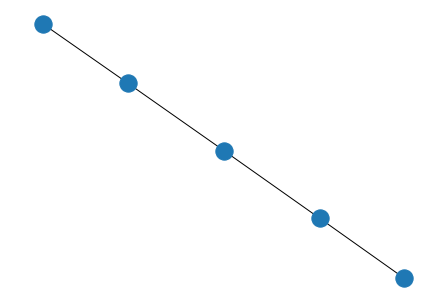

In [19]:
"""Visualize the qubit connectivity."""
graph = lattice.qubit_topology()
nx.draw(graph)

In [20]:
"""Get an ansatz and visualize it."""
circ, creg = vqls.yansatz(lattice)
print(circ)

DECLARE ro BIT[5]
DECLARE theta REAL[5]
RY(theta[0]) 10
RY(theta[1]) 11
RY(theta[2]) 12
RY(theta[3]) 13
RY(theta[4]) 14



In [21]:
"""Cost function for linear system 1."""
def costLS1(angles, min_weight: float = 0.0, verbose: bool = False):
    val = vqls.energy(angles, ham, circ, creg, lattice, min_weight=min_weight, shots=10000)
    if verbose:
        print("Current angles:", angles)
        print("Current energy:", val)
    return val

In [24]:
"""Do the optimization."""
start = time.time()
res = minimize(costLS1, x0=[pi / 2] * n, method="COBYLA", args=(0.01, True))
print("Runtime:", (time.time() - start) // 60, "minutes.")

/home/ryan/phd/rigettiVQLS/pyquil/lib/python3.6/site-packages/rpcq/_client.py:196: UserWarning: SIMPLE-WARNING: Chip specification contained fidelity 1.0d0 > 0.99999d0. Truncating to 0.99999d0.
  warn(f"{warning.kind}: {warning.body}")
/home/ryan/phd/rigettiVQLS/pyquil/lib/python3.6/site-packages/rpcq/_client.py:196: UserWarning: SIMPLE-WARNING: Chip specification contained fidelity 0.99999956012908d0 > 0.99999d0. Truncating to 0.99999d0.
  warn(f"{warning.kind}: {warning.body}")


Current angles: [1.571 1.571 1.571 1.571 1.571]
Current energy: 0.039300999999994236
Current angles: [2.571 1.571 1.571 1.571 1.571]
Current energy: 0.18388274999999593
Current angles: [1.571 2.571 1.571 1.571 1.571]
Current energy: 0.16383474999999625
Current angles: [1.571 1.571 2.571 1.571 1.571]
Current energy: 0.3669907499999956
Current angles: [1.571 1.571 1.571 2.571 1.571]
Current energy: 0.3724597499999948
Current angles: [1.571 1.571 1.571 1.571 2.571]
Current energy: 0.3691847499999955
Current angles: [1.331 1.364 1.027 1.018 1.024]
Current energy: 0.40155849999999593
Current angles: [1.451 1.468 1.299 1.295 1.297]
Current energy: 0.15294124999999503
Current angles: [1.543 1.547 1.801 1.507 1.507]
Current energy: 0.06844799999999511
Current angles: [1.652 1.476 1.571 1.571 1.571]
Current energy: 0.07403424999999467
Current angles: [1.73  1.754 1.57  1.528 1.529]
Current energy: 0.017547999999995158
Current angles: [1.73  1.754 1.57  1.616 1.44 ]
Current energy: 0.01788049999

In [25]:
print("Minimum cost found:", res.fun)
print("Best found angles:", res.x)

Minimum cost found: 0.0011579999999947188
Best found angles: [1.6   1.992 1.497 1.597 1.598]


In [26]:
qxvec = vqls.qsolution(circ, res.x)
print(qxvec)

[0.135+0.j 0.139+0.j 0.209+0.j 0.215+0.j 0.126+0.j 0.129+0.j 0.194+0.j
 0.199+0.j 0.139+0.j 0.143+0.j 0.214+0.j 0.22 +0.j 0.129+0.j 0.133+0.j
 0.199+0.j 0.205+0.j 0.139+0.j 0.143+0.j 0.214+0.j 0.221+0.j 0.129+0.j
 0.133+0.j 0.199+0.j 0.205+0.j 0.142+0.j 0.147+0.j 0.22 +0.j 0.226+0.j
 0.132+0.j 0.136+0.j 0.204+0.j 0.21 +0.j]


In [27]:
"""Compare to classical solution."""
# Get the classical solution
Amat = vqls.matrix(Acoeffs, Aterms)
bvec = vqls.vector(Bcoeffs, Bterms)
xvec = np.linalg.solve(Amat, bvec)
xvec /= np.linalg.norm(xvec)

# ===========================
# Compare classical x vectors
# ===========================

print("Comparing x vectors:")
print("====================")

# Compute the fidelity
fidelity = abs(np.dot(qxvec.conj(), xvec))**2
print(r"| < xquantum | xclassical > |^2 =", round(fidelity, 2))

# Compute the L2 distance
l2dist = np.linalg.norm(qxvec - xvec, ord=2)**2
print(r"|| xquantum - xclassical ||^2 =", round(l2dist, 2))

# ==========================
# Compare solution b vectors
# ==========================

print("\nComparing b vectors:")
print("====================")

# Compute |qbvec> = A |theta optimal>
qbvec = Amat @ qxvec
qbvec /= np.linalg.norm(qbvec)
bfidelity = abs(np.dot(bvec.conj(), qbvec))**2
print(r"| < bquantum | bclassical > |^2 =", round(bfidelity, 2))

bl2dist = np.linalg.norm(qbvec - bvec, ord=2)**2
print(r"|| bquantum - bclassical ||^2 =", round(bl2dist, 2))

Comparing x vectors:
| < xquantum | xclassical > |^2 = 0.93
|| xquantum - xclassical ||^2 = 0.07

Comparing b vectors:
| < bquantum | bclassical > |^2 = 0.93
|| bquantum - bclassical ||^2 = 0.07


# <p style="text-align: center;"> Linear System 2 </p>

The second linear system we consider is formed from the Ising model.

\begin{equation}
    A_2 := \frac{1}{\zeta} \left(\eta I + \sum_{j=1}^{n} X_j + J \sum_{j=1}^{n-1}Z_jZ_{j+1} \right)
\end{equation}

In [ ]:
def get_Acoeffs_Aterms_LS2(n: int, zeta: float, eta: float, J: float):
    """Returns linear system 2 expressed as weighted Pauli sum."""
    if n < 0:
        raise ValueError("Number of qubits must be >= 1.")
    # Add the identity
    Acoeffs = [eta / zeta]
    Aterms = ["I" * n]
    
    # Add the X terms
    Acoeffs += [1 / zeta] * n
    xbase = "X" + "I" * (n - 1)
    for ii in range(n, 0, -1):
        Aterms.append(xbase[ii:] + xbase[:ii])
        
    # Add the ZZ terms
    Acoeffs += [J / zeta] * (n - 1)
    zzbase = "ZZ" + "I" * (n - 2)
    for ii in range(n, 1, -1):
        Aterms.append(zzbase[ii:] + zzbase[:ii])
    
    return Acoeffs, Aterms

In [ ]:
def yansatzCZ(computer):
    """Returns a Ry ansatz with some entanglement."""
    # Grab the qubits
    qubits = tuple(computer.qubits())
    n = len(qubits)
    
    # Get a circuit and classical memory register
    circ = Program()
    creg = circ.declare("ro", memory_type="BIT", memory_size=n)

    # Define parameters for the ansatz
    angles = circ.declare("theta", memory_type="REAL", memory_size=n)

    # Add the ansatz
    circ += [gates.RY(angles[ii], qubits[ii]) for ii in range(n)]
    circ += [gates.CZ(qubits[ii], qubits[ii + 1]) for ii in range(n - 1)]
    
    return circ, creg

In [ ]:
"""Unit tests for getting LS2."""
Acoeffs, Aterms = get_Acoeffs_Aterms_LS2(4, 1, 1, 0.1)
assert Acoeffs == [1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 0.1]
assert Aterms == ['IIII', 'XIII', 'IXII', 'IIXI', 'IIIX', 'ZZII', 'IZZI', 'IIZZ']

In [ ]:
"""Terms in effective Hamiltonian for second linear system."""
# Number of qubits
n = 3

# Constants
zeta = 1.0
J = 0.1
eta = 1.0

# |b> = H|0>
Bcoeffs = [1 / 2**(n / 2)] * 2**n
paulis = [["X", "Z"]] * n
prods = list(product(*paulis))
Bterms = ["".join(p) for p in prods]

# Bcoeffs = [1 / 2**(1 / 2)] * 2
# Bterms = ["IXIII", "XIXII"]

# Linear system in weighted Paulis
Acoeffs, Aterms = get_Acoeffs_Aterms_LS2(n, zeta, eta, J)

# Normalize A and B coefficients
# TODO: Do this calculation in terms of the coefficients, not the explicit matrix
Amat = vqls.matrix(Acoeffs, Aterms)
Anorm = np.linalg.norm(Amat, ord=2)
Acoeffs = np.array(Acoeffs)
Acoeffs /= Anorm

Bmat = vqls.matrix(Bcoeffs, Bterms)
Bnorm = np.linalg.norm(Bmat, ord=2)
Bcoeffs = np.array(Bcoeffs)
Bcoeffs /= Bnorm

ham2 = vqls.effective_hamiltonian(Acoeffs, Aterms, Bcoeffs, Bterms)

# Display the effective Hamiltonian
nterms = len(ham2)
num = 0
min_weight = 0.01
print("Number of terms:", nterms)
print("H = ")
for ii in range(nterms):
    if abs(ham2[ii][0]) > min_weight:
        num += 1
    print(f"{round(ham2[ii][0], 3)} \t* \t{ham2[ii][1]}", (lambda ii: "+" if ii < nterms - 1 else "")(ii))

print(f"Number of terms with |coeff| > {min_weight} = {num}")

In [ ]:
"""View matrix of linear system we are solving."""
Amat = vqls.matrix(Acoeffs, Aterms)
print("Matrix A =")
print(np.real(Amat))

In [ ]:
"""View effective Hamiltonian matrix."""
Hmat = vqls.matrix_of_hamiltonian(ham2)
print("Effective Hamiltonian =")
print(np.real(Hmat))

In [ ]:
"""Get a computer to run on."""
qcomputer = f"Aspen-7-{n}Q-B"
lattice5q = get_qc(qcomputer, as_qvm=True)  # Change to as_qvm=False to run on QC. Must have reservation.

In [ ]:
"""Get an ansatz."""
circ, creg = vqls.yansatz(lattice5q)
print(circ)

In [ ]:
"""Cost function for linear system 2."""
def costLS2(angles, min_weight: float = 0.0, verbose: bool = False):
    val = vqls.energy(angles, ham2, circ, creg, lattice5q, min_weight=min_weight, shots=10000)
    if verbose:
        print("Current angles:", angles)
        print("Current energy:", val)
    return val

In [ ]:
"""Optimization: Testing fmin functions from scipy.optimize."""
start = time.time()
res = fmin(costLS2, x0=[pi / 2] * n, ftol=0.001, maxfun=50, args=(0.01, True,))
print("Runtime:", (time.time() - start) // 60, "minutes.")

In [ ]:
"""Do the optimization."""
start = time.time()
res = minimize(costLS2, x0=[pi / 2] * n, method="COBYLA", args=(0.00, True))
print("Runtime:", (time.time() - start) // 60, "minutes.")

In [ ]:
print("Optimal angles:", res.x)

In [ ]:
"""Evaluate the energy at the best found angles (using all terms)."""
vqls.energy(res.x, ham2, circ, creg, lattice5q, min_weight=0)

In [ ]:
"""Get the quantum solution (x vector)."""
qxvec = vqls.qsolution(circ, res.x)
print(*np.real(qxvec), sep="\n")

In [ ]:
"""Compare to classical solution."""
# Get the classical solution
Amat = vqls.matrix(Acoeffs, Aterms)
bvec = vqls.vector(Bcoeffs, Bterms)
xvec = np.linalg.solve(Amat, bvec)
xvec /= np.linalg.norm(xvec)

# ===========================
# Compare classical x vectors
# ===========================

print("Comparing x vectors:")
print("====================")

# Compute the fidelity
fidelity = abs(np.dot(qxvec.conj(), xvec))**2
print(r"| < xquantum | xclassical > |^2 =", round(fidelity, 2))

# Compute the L2 distance
l2dist = np.linalg.norm(qxvec - xvec, ord=2)**2
print(r"|| xquantum - xclassical ||^2 =", round(l2dist, 2))

# ==========================
# Compare solution b vectors
# ==========================

print("\nComparing b vectors:")
print("====================")

# Compute |qbvec> = A |theta optimal>
qbvec = Amat @ qxvec
qbvec /= np.linalg.norm(qbvec)
bfidelity = abs(np.dot(bvec.conj(), qbvec))**2
print(r"| < bquantum | bclassical > |^2 =", round(bfidelity, 2))

bl2dist = np.linalg.norm(qbvec - bvec, ord=2)**2
print(r"|| bquantum - bclassical ||^2 =", round(bl2dist, 2))

### Figure out what tf is going on

In [ ]:
evals, evecs = np.linalg.eigh(Hmat)
print(*evals, sep="\n")

In [ ]:
bfound = Amat @ xvec
bfound /= np.linalg.norm(bfound, ord=2)
bfound

In [ ]:
bvec

In [ ]:
xvec

In [ ]:
qxvec

In [ ]:
bvec

In [ ]:
print("Index \t Eigenvalue \t f(xvec, evec[index])")
for ii in range(len(evals)):
    print(ii, "\t", round(evals[ii], 5), "\t", round(abs(np.dot(xvec.conj(), evecs[:, ii])), 3))

In [ ]:
print(*np.real(qxvec), sep="\n")

In [ ]:
print(*np.real(evecs[:, 3]), sep="\n")

In [ ]:
qbvec = Amat @ qxvec
qbvec /= np.linalg.norm(qbvec)

abs(np.dot(bvec.conj(), qbvec))**2

## Running on a Quantum Computer

This notebook was made into a script that could be run on Rigetti's Quantum Cloud Services. In particular, we used a three qubit lattice "Aspen-4-3Q-A," the fidelity/noise characterization of which can be found online. In the cell below, we load energy vs iteration data that was computed using our VQE algorithm on this lattice. We then plot it against the simulator result to compare the difference.

In [ ]:
"""Plot the QPU energy vs iteration data obtained by running on Rigetti QCS."""
# Read in the files
qpu_energy1 = np.loadtxt("qpu-energy-iteration1.txt")
qpu_energy2 = np.loadtxt("qpu-energy-iteration2.txt")

# Do the plotting
plt.figure(figsize=(10, 5))
plt.plot(energies, "--o", linewidth=3, label="Simulator")
plt.xlabel("Iteration", fontsize=14, fontweight="bold")
plt.ylabel("Energy", fontsize=14, fontweight="bold")

plt.plot(qpu_energy1, "--o", linewidth=3, label="Raw QPU Run 1")
plt.plot(qpu_energy2, "--o", linewidth=3, label="Raw QPU Run 2")

# Put a line at the actual ground state energy (see below)
GSENERGY = 0.53232723
plt.plot(GSENERGY * np.ones_like(energies), linewidth=3, label="Analytic Energy")

plt.grid()
plt.legend();

## Error Mitigation

The QPU data above has a significant vertical shift from the simulator data, but generally the same "shape." This shift is present because of decoherence, gate application errors, measurement errors, and other noise in the system. It can be accounted for by running a set of "benchmark circuits" on the QPU prior to running the actual algorithm. These benchmark circuits are simple circuits, such as NOT and MEASURE, for which one knows the actual output. The vertical shift in this benchmark circuit can then be tested for and subtracted from the final computed energies to get more accurate results. Other methods are also possible, and this is an area of active research.

Here, we employ a similar idea, but instead of running a benchmark circuit, we just subtract off the difference of the initial energies on the QPU and on the simulator. The cell below implements this and plots the result again.

In [ ]:
"""Plot the error mitigated QPU energy vs iteration data obtained by running on Rigetti QCS."""
# Constant shift amount. In practice, this would be obtained by running a "benchmark circuit."
# Here, we just set the value based on the above curves
shift = 0.3

# Read in the files
qpu_energy1 = np.loadtxt("qpu-energy-iteration1.txt")
qpu_energy2 = np.loadtxt("qpu-energy-iteration2.txt")

# Subtract off the shift
qpu_energy1 -= shift
qpu_energy2 -= shift

# Do the plotting
plt.figure(figsize=(10, 5))
plt.plot(energies, "--o", linewidth=3, label="Simulator")
plt.xlabel("Iteration", fontsize=14, fontweight="bold")
plt.ylabel("Energy", fontsize=14, fontweight="bold")

plt.plot(qpu_energy1, "--o", linewidth=3, label="Error Mitigated QPU Run 1")
plt.plot(qpu_energy2, "--o", linewidth=3, label="Error Mitigated QPU Run 2")

# Put a line at the actual ground state energy (see below)
GSENERGY = 0.53232723
plt.plot(GSENERGY * np.ones_like(energies), linewidth=3, label="Analytic Energy")

plt.grid()
plt.legend();

## Conclusions

## Acknowledgements

Thank coauthors and Rigetti.

## References

[1] VQLS

[2] HHL

[3] QLSP via QSVE

[4] Yigit's adiabatic algorithm

[5] VQE Original paper

[6] Theory of VQE

[7] Ryan LaRose et al., [Implementing variational quantum algorithms](https://github.com/rmlarose/qcbq/blob/master/tutorials/04qaoa/qcbq_tutorial4b_implement_qaoa-INSTRUCTOR.ipynb), MSU-IBM Quantum computing bootcamp with Qiskit, 2019. 